# Latar Belakang
 Transportation Security Administration (TSA) adalah sebuah badan dari Departemen Keamanan Dalam Negeri Amerika Serikat (DHS) yang memiliki wewenang atas keamanan sistem transportasi di dalam, dan menghubungkan ke Amerika Serikat. TSA mencatat dan bertanggung jawab pada setiap aduan yang diajukan penumpang / pelapor. TSA harus mengeluarkan ganti rugi (amount close) untuk setiap aduan yang telah terkonfirmasi. 




## Pernyataan Masalah
TSA ingin mengetahui **bandara mana saja yang paling rentan terhadap keamanan** dan apa yang harus diatur kepada bandara agar dapat **mengurangi ongkos ganti rugi (amount close)** dari TSA.


Sebagai seorang *data analyst*, kita akan mencoba menjawab pertanyaan berikut:

**Bagaimana kerentanan setiap bandara, dan apa yang harus dilakukan untuk meminimalasir cost dari Amount Close ?**

# Data
Untuk menjawab pertanyaan di atas, kita akan menganalisa data peserta yang sudah dikumpulkan oleh TSA. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
from scipy.stats import normaltest, chi2_contingency, mannwhitneyu, ttest_ind

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('tsa_claims.csv')
display(df.head(),df.tail())

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
0,0909802M,4-Jan-02,12/12/2002 0:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,$350.00,Approved,$350.00,Approve in Full
1,0202417M,2-Feb-02,1/16/2004 0:00,SEA,Seattle-Tacoma International,NaN,Property Damage,Checked Baggage,Luggage (all types including footlockers),$100.00,Settled,$50.00,Settle
2,0202445M,4-Feb-02,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,$278.88,Settled,$227.92,Settle
3,0909816M,7-Feb-02,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),$50.00,Approved,$50.00,Approve in Full
4,2005032379513,18-Feb-02,2/5/2005 0:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,$84.79,Approved,$84.79,Approve in Full


,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
204262,2015120427297,20-Nov-15,16-Oct-15,-,-,-,Property Damage,Checked Baggage,Baggage/Cases/Purses; Books; Magazines & Other...,-,-,NaN,NaN
204263,2015123027969,17-Dec-15,2-Dec-15,-,-,-,Property Damage,Checked Baggage,Audio/Video; Home Decor,-,-,NaN,NaN
204264,2016010428072,22-Dec-15,20-Dec-15,-,-,-,Passenger Property Loss,Checked Baggage,Clothing,-,-,NaN,NaN
204265,2016011328300,30-Dec-15,28-Dec-15,-,-,-,Passenger Property Loss,Checked Baggage,Tools & Home Improvement Supplies,-,-,NaN,NaN
204266,2015123128015,31-Dec-15,23-Nov-15,-,-,-,Passenger Property Loss,Checkpoint,Personal Accessories,-,-,NaN,NaN


Data set ini berjumlah 204.266 baris dan 12 kolom, dengan penjelasan kolom sebagai berikut:
* Clain Number = Nomer ID unik untuk setiap aduan 
* Date Received = Tanggal laporan aduan diterima
* Incident Date = Tanggal terjadinya insinden menurut pelapor
* Airport Code = Nomor ID uni untuk setiap Bandara tempat terjadi nya aduan
* Airport Name = Nama Bandara tempat terjadi nya aduan
* Claim Type = Tipe aduan dari pelapor
* Claim Site = Letak insiden aduan terjadi
* Item = Objek dalam insiden
* Claim Amount = Nominal biaya pengajuan aduan
* Status = Status proses pengajuan aduan
* Close Amount = Nominal biaya yang terbayarkan oleh TSA
* Disposition = Status proses akhir dari aduan pelapor

## Data Understanding and Cleaning

Sebelum masuk ke dalam analisis, kita perlu mengenal dataset kita lebih jauh dalam tahapan *data understanding*. Dari proses ini, kita akan tahu anomali-anomali apa saja yang terdapat di dalam dataset kita dan perlu ditangani dalam tahapan *data cleaning*. Setiap penangan anomali yang dilakukan, akan disertai dengan justifikasi langkah yang diambil, baik secara *domain knowledge* maupun secara statistik.

In [4]:
print(f'Jumlah baris dan kolom di dataset df adalah {df.shape}')
df.info()

Jumlah baris dan kolom di dataset df adalah (204267, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204267 entries, 0 to 204266
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Claim Number   204267 non-null  object
 1   Date Received  204004 non-null  object
 2   Incident Date  202084 non-null  object
 3   Airport Code   195743 non-null  object
 4   Airport Name   195743 non-null  object
 5   Airline Name   169893 non-null  object
 6   Claim Type     196354 non-null  object
 7   Claim Site     203527 non-null  object
 8   Item           200301 non-null  object
 9   Claim Amount   200224 non-null  object
 10  Status         204262 non-null  object
 11  Close Amount   135315 non-null  object
 12  Disposition    131359 non-null  object
dtypes: object(13)
memory usage: 20.3+ MB


dapat dilihat sekilas dari tabel di atas:
1. Missing data nya cukup banyak (nanti akan dianalisa lebih jauh)
1. Tipe data nya semua masih object, padahal ada yang nominal uang yang harusnya integer maupun tanggal yang harusnya date

In [5]:
display(df.describe(), df.describe(include='object'))

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
count,204267,204004,202084,195743,195743,169893,196354,203527,200301,200224,204262,135315,131359
unique,204258,4007,26807,465,485,318,11,6,4704,36117,15,17162,3
top,2013121110011,5-Dec-03,12/27/2004 0:00,LAX,John F. Kennedy International,American Airlines,Passenger Property Loss,Checked Baggage,Other,$0.00,Denied,$0.00,Deny
freq,2,682,144,9596,9232,17553,117868,159753,36908,28445,68339,71546,68382


,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
count,204267,204004,202084,195743,195743,169893,196354,203527,200301,200224,204262,135315,131359
unique,204258,4007,26807,465,485,318,11,6,4704,36117,15,17162,3
top,2013121110011,5-Dec-03,12/27/2004 0:00,LAX,John F. Kennedy International,American Airlines,Passenger Property Loss,Checked Baggage,Other,$0.00,Denied,$0.00,Deny
freq,2,682,144,9596,9232,17553,117868,159753,36908,28445,68339,71546,68382


In [6]:
pd.set_option('display.max_colwidth', -1)
# data unik di tiap kolom
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

Column Name  Number of Unique  \
0   Claim Number   204258             
1   Date Received  4007               
2   Incident Date  26807              
3   Airport Code   465                
4   Airport Name   485                
5   Airline Name   318                
6   Claim Type     11                 
7   Claim Site     6                  
8   Item           4704               
9   Claim Amount   36117              
10  Status         15                 
11  Close Amount   17162              
12  Disposition    3                  

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

Dari data di atas, ada beberapa variabel yang tidak revelan dalam tujuan dari analisis ini, seperti data `Item` dan `Claim Amount`

Karena kita hanya melihat biaya yang sudah dibayarkan oleh TSA (bukan biaya aduan), maka kita tidak menggunakan `Claim Amount`, melainkan menggunakan `Close Amount`

Kemudian, antara `Status` dan `Disposition` perlu dianalisa mana yang lebih layak di drop:
* Kita lihat apakah `Approve in Full` pada `Disposition` sudah pasti `Approved` pada `Status`?
* Kita lihat apakah `Approved` pada `Status` sudah pasti `Approve in Full` pada `Disposition`?

In [7]:
pd.DataFrame(df[df['Disposition']=='Approve in Full'].groupby('Status').count()['Disposition'])

,Disposition
Status,
Approved,34999
Canceled,3
In litigation,2
In review,1
Insufficient; one of the following items required: sum certain; statement of fact; signature; location of incident; and date.,5


In [8]:
pd.DataFrame(df[df['Status']=='Approved'].groupby('Disposition').count()['Status'])

,Status
Disposition,
Approve in Full,34999


Ternyata, `Status` yang `Approved` sudah pasti `Approve in Full`, sehingga yang kita **drop** cukup `Disposition`

Yang dibutuhkan hanya data approved saja

In [9]:
df.drop(['Item','Claim Amount','Disposition'], axis = 1, inplace = True)

In [10]:
df

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Status,Close Amount
0,0909802M,4-Jan-02,12/12/2002 0:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Approved,$350.00
1,0202417M,2-Feb-02,1/16/2004 0:00,SEA,Seattle-Tacoma International,NaN,Property Damage,Checked Baggage,Settled,$50.00
2,0202445M,4-Feb-02,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Settled,$227.92
3,0909816M,7-Feb-02,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Approved,$50.00
4,2005032379513,18-Feb-02,2/5/2005 0:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Approved,$84.79
...,...,...,...,...,...,...,...,...,...,...
204262,2015120427297,20-Nov-15,16-Oct-15,-,-,-,Property Damage,Checked Baggage,-,NaN
204263,2015123027969,17-Dec-15,2-Dec-15,-,-,-,Property Damage,Checked Baggage,-,NaN
204264,2016010428072,22-Dec-15,20-Dec-15,-,-,-,Passenger Property Loss,Checked Baggage,-,NaN
204265,2016011328300,30-Dec-15,28-Dec-15,-,-,-,Passenger Property Loss,Checked Baggage,-,NaN


## Missing Value

In [11]:
# banyak data '-' bisa diasumsikan isinya kosong, jadi bisa kita ganti dengan NaN

df = df.replace('-', np.nan)
df

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Status,Close Amount
0,0909802M,4-Jan-02,12/12/2002 0:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Approved,$350.00
1,0202417M,2-Feb-02,1/16/2004 0:00,SEA,Seattle-Tacoma International,NaN,Property Damage,Checked Baggage,Settled,$50.00
2,0202445M,4-Feb-02,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Settled,$227.92
3,0909816M,7-Feb-02,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Approved,$50.00
4,2005032379513,18-Feb-02,2/5/2005 0:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Approved,$84.79
...,...,...,...,...,...,...,...,...,...,...
204262,2015120427297,20-Nov-15,16-Oct-15,NaN,NaN,NaN,Property Damage,Checked Baggage,NaN,NaN
204263,2015123027969,17-Dec-15,2-Dec-15,NaN,NaN,NaN,Property Damage,Checked Baggage,NaN,NaN
204264,2016010428072,22-Dec-15,20-Dec-15,NaN,NaN,NaN,Passenger Property Loss,Checked Baggage,NaN,NaN
204265,2016011328300,30-Dec-15,28-Dec-15,NaN,NaN,NaN,Passenger Property Loss,Checked Baggage,NaN,NaN


In [12]:
# persentase missing value di tiap kolom 

missing = pd.DataFrame(df.isna().sum()/df.shape[0]*100)
missing.rename({0: 'persentase'}, axis='columns', inplace = True)
missing['jumlah'] = df.isna().sum()
missing

,persentase,jumlah
Claim Number,0.000000,0
Date Received,0.128753,263
Incident Date,1.068699,2183
Airport Code,4.388864,8965
Airport Name,4.388864,8965
Airline Name,18.907117,38621
Claim Type,4.011906,8195
Claim Site,0.497388,1016
Status,6.245257,12757
Close Amount,33.755820,68952


<AxesSubplot:>

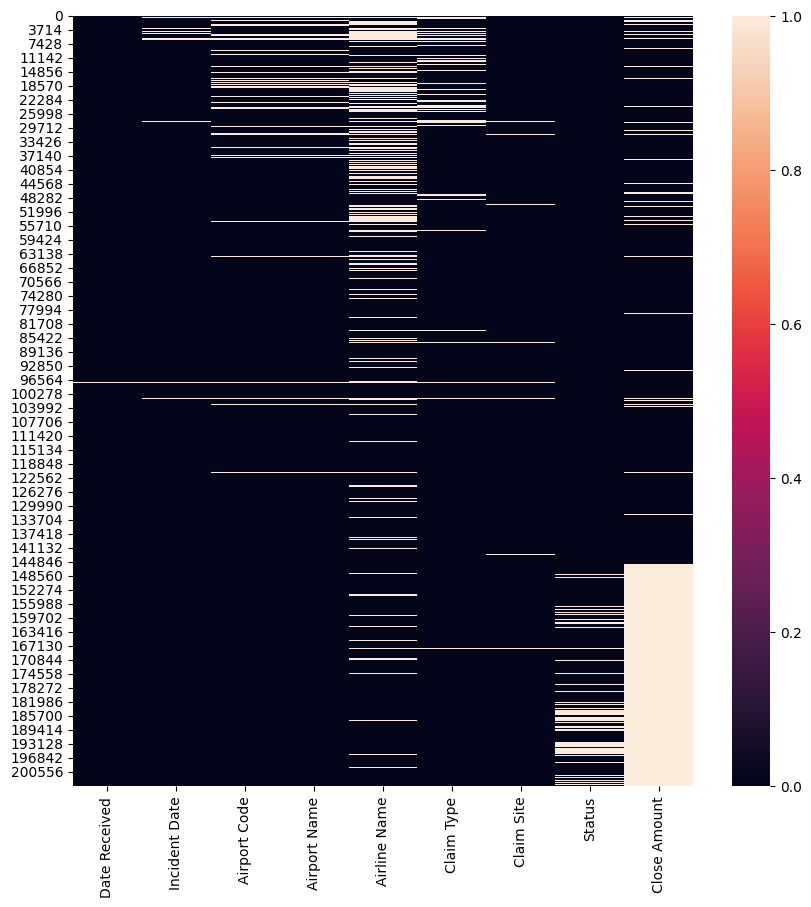

In [13]:
# Sebaran missing value di dalam data

plt.figure(figsize=(10,10))
sns.heatmap(df[['Date Received','Incident Date','Airport Code','Airport Name','Airline Name','Claim Type','Claim Site','Status','Close Amount']].isna())

*Catatan:*
terdapat cukup banyak data '-' di dalam keseluruhan data. kita asumsikan data '-' artinya data kosong sehingga bisa diganti NaN

Secara garis besar:  
* *missing value* di kolom `Airline Name` dan `Close Amount` memiliki proporsi yang cukup tinggi (>10%), dengan missing value di kolom `Close Amount` mencapai 33.75%.
* *missing value* di kolom `Airport Code` `Airport Name` dan `Airline Name` memiliki sebaran yang terlihat berkaitan, jika data di `Airport Code` `Airport Name` kosong, maka kemungkinan besar data di `Airline Name` juga kosong. 

Ada 2 cara untuk menangani *missing value*:
* pertama, menghapus baris/kolom yang berisi *missing value*. Cara ini tidak disarankan dalam kasus kita, karena jumlah missing value yang tergolong cukup tinggi (sampai 33%).
* kedua, mengisi data yang hilang. Cara ini lebih disarankan. Ada beberapa metode yang bisa digunakan untuk mengisi missing value, cara yang paling baik adalah dengan mengisi data yang hilang dengan nilai sebenarnya, atau sedekat mungkin dengan nilai asli. Dalam kasus ini, kita akan mencoba mengisi *missing value* berdasarkan kolom lain yang secara domain knowledge atau secara statistik berkaitan dengan kolom yang memiliki *missing value*. Jika masih ada kolom yang tidak bisa diisi, barulah kita mengisi dengan angka *mean, median* atau *modus*. Menghapus data akan menjadi opsi terakhir.

Kita sudah melihat gambaran kasar anomali di dalam data kita, sekarang, mari kita lihat dan tangani tiap-tiap anomali secara lebih jauh.  


### Date Received dan Incident Date
Sebelum memulai, mari kita ubah format data di kolom `Date Received` dan `Incident Date` menjadi format date yang sama.

In [14]:
df.head(5)

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Status,Close Amount
0,0909802M,4-Jan-02,12/12/2002 0:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Approved,$350.00
1,0202417M,2-Feb-02,1/16/2004 0:00,SEA,Seattle-Tacoma International,NaN,Property Damage,Checked Baggage,Settled,$50.00
2,0202445M,4-Feb-02,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Settled,$227.92
3,0909816M,7-Feb-02,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Approved,$50.00
4,2005032379513,18-Feb-02,2/5/2005 0:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Approved,$84.79


In [15]:
c=[]
for i in range(len(df['Incident Date'])):
    if len(str(df['Incident Date'][i])) == 17:
        c.append(i)
dferror = df.iloc[c]

In [16]:
df['Date Received'] = pd.to_datetime(df['Date Received'])
z=[]
for i in range(len(df['Incident Date'])):
    if len(str(df['Incident Date'][i])) == 17:
        z.append(i)
month = {'Jan':'1', 'Feb':'2', 'Mar':'3', 'Apr':'4', 'May':'5', 'Jun':'6', 'Jul':'7', 'Aug':'8', 'Sep':'9', 'Oct':'10', 'Nov':'11', 'Dec':'12'}

for i in z:
    x = str(df['Incident Date'][i])
    y = str(df['Date Received'][i].year)
    for j,k in month.items():
        if x[3:6] == j.upper():
            a = str(y+'/'+month[j]+'/'+x[:2])
            df.at[i,'Incident Date']=a
df['Incident Date']=pd.to_datetime(df['Incident Date'])

In [17]:
df

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Status,Close Amount
0,0909802M,2002-01-04,2002-12-12,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Approved,$350.00
1,0202417M,2002-02-02,2004-01-16,SEA,Seattle-Tacoma International,NaN,Property Damage,Checked Baggage,Settled,$50.00
2,0202445M,2002-02-04,2003-11-26,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Settled,$227.92
3,0909816M,2002-02-07,2003-01-06,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Approved,$50.00
4,2005032379513,2002-02-18,2005-02-05,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Approved,$84.79
...,...,...,...,...,...,...,...,...,...,...
204262,2015120427297,2015-11-20,2015-10-16,NaN,NaN,NaN,Property Damage,Checked Baggage,NaN,NaN
204263,2015123027969,2015-12-17,2015-12-02,NaN,NaN,NaN,Property Damage,Checked Baggage,NaN,NaN
204264,2016010428072,2015-12-22,2015-12-20,NaN,NaN,NaN,Passenger Property Loss,Checked Baggage,NaN,NaN
204265,2016011328300,2015-12-30,2015-12-28,NaN,NaN,NaN,Passenger Property Loss,Checked Baggage,NaN,NaN


Terlihat di atas bahwa kolom`Date Received` dan `Incident Date` sudah berubah.

Kolom `Date Received` dan `Incident Date` **sudah disamakan format date** nya.

Sekarang baru kita akan menangani missing value nya:
* Untuk mencapai tujuan dari analisis ini, kita cukup gunakan `Incident Date`
* Fungsi dari `Date Received` adalah untuk mengisi `Incident Date` dengan asumsi data diterima TSA pada hari kejadian 

Sebelum melakukan tindakan pada *missing value* dari `Incident Date`, kita perlu memfilter `Status` nya `Approved` saja karena yang dibutuhkan dalam analisis ini cukup data yang *Approved*

In [18]:
df = df[df['Status']=='Approved']
df

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Status,Close Amount
0,0909802M,2002-01-04,2002-12-12 00:00:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Approved,$350.00
3,0909816M,2002-02-07,2003-01-06 00:00:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Approved,$50.00
4,2005032379513,2002-02-18,2005-02-05 00:00:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Approved,$84.79
6,2007050124750,2002-04-30,2007-04-26 00:00:00,PHL,Philadelphia International Airport,USAir,Passenger Property Loss,Checked Baggage,Approved,$106.52
7,12772,2002-06-20,2002-05-09 00:00:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Southwest Airlines,NaN,Checkpoint,Approved,$75.00
...,...,...,...,...,...,...,...,...,...,...
145078,2010010667223,2009-12-30,2009-12-15 13:15:00,ORD,Chicago O'Hare International Airport,UAL,Property Damage,Checked Baggage,Approved,$37.82
145079,2010010667225,2009-12-30,2009-12-16 10:59:00,ALB,Albany International,Delta Air Lines,Property Damage,Checked Baggage,Approved,$64.00
145080,2010010667229,2009-12-30,2009-10-06 00:00:00,LAX,Los Angeles International Airport,American Airlines,Passenger Property Loss,Checked Baggage,Approved,$49.95
145135,2010010667197,2009-12-31,2009-12-10 12:40:00,DEN,Denver International Airport,UAL,Passenger Property Loss,Checked Baggage,Approved,$70.00


In [19]:
df.isna().sum()

Claim Number     0   
Date Received    38  
Incident Date    236 
Airport Code     1407
Airport Name     1407
Airline Name     9832
Claim Type       1742
Claim Site       64  
Status           0   
Close Amount     133 
dtype: int64

In [20]:
a = []
for i in range(0, df.shape[0]):
    if df.iloc[i,1] == df.iloc[i,2]:
        a.append(i)
print('jumlah data Incident Date dan Date Received yang sama sebanyak', len(a))
print('atau proporsinya sebesar {}'.format(len(a)/df.shape[0]*100))

jumlah data Incident Date dan Date Received yang sama sebanyak 30
atau proporsinya sebesar 0.0857167347638504


Kita berasumsi bahwa waktu peloran aduan atau `Data Received` kerap kali berbarengan dengan waktu kejadian atau`Incident Date`. 

Oleh karena itu, **untuk mengisi `Incident Date` yang kosong kita isi dengan data dari kolom `Date Received`** 

Namun, sebelumnya kita perlu mengedrop seluruh missing data dari `Date Received` karena setelah ini kita akan memasukkan data dalam `Date Received` ke dalam data NaN dari kolom `Incident Date`

In [21]:
df.dropna(subset=['Date Received'],inplace=True)
df.isna().sum()

Claim Number     0   
Date Received    0   
Incident Date    232 
Airport Code     1402
Airport Name     1402
Airline Name     9816
Claim Type       1738
Claim Site       62  
Status           0   
Close Amount     131 
dtype: int64

dapat dilihat di atas bahwa missing data dari kolom `Date Received` sudah tidak ada dan missing data dari `Incident Date` tinggal 232. Kita masukkan `Date Received` ke dalam `Incident Date`

In [22]:
df['Incident Date'] = df['Incident Date'].fillna(value = df['Date Received'])

In [23]:
df['Incident Date']=pd.to_datetime(df['Incident Date'])

In [24]:
df.isna().sum()

Claim Number     0   
Date Received    0   
Incident Date    0   
Airport Code     1402
Airport Name     1402
Airline Name     9816
Claim Type       1738
Claim Site       62  
Status           0   
Close Amount     131 
dtype: int64

dapat dilihat diatas bahwa data `Incident Date` sudah **tidak ada** yang missing

In [25]:
# mengecek apakah type data `Incident Date` berubah atau tidak
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34961 entries, 0 to 145136
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Claim Number   34961 non-null  object        
 1   Date Received  34961 non-null  datetime64[ns]
 2   Incident Date  34961 non-null  datetime64[ns]
 3   Airport Code   33559 non-null  object        
 4   Airport Name   33559 non-null  object        
 5   Airline Name   25145 non-null  object        
 6   Claim Type     33223 non-null  object        
 7   Claim Site     34899 non-null  object        
 8   Status         34961 non-null  object        
 9   Close Amount   34830 non-null  object        
dtypes: datetime64[ns](2), object(8)
memory usage: 2.9+ MB


Memisahkan Hari, Tanggal, Bulan, Tahun, dan Jam untuk memperkaya fitur untuk analisis

In [26]:
df['dayname'] = df['Incident Date'].dt.day_name()
df['day'] = df['Incident Date'].dt.day
df['month'] = df['Incident Date'].dt.month
df['year'] = df['Incident Date'].dt.year
df['hour'] = df['Incident Date'].dt.hour

Karena sudah tidak membutuhkan `Date Received`, kita bisa mengedrop nya

In [27]:
df.drop(['Date Received'],axis =1, inplace=True)

In [28]:
df

,Claim Number,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Status,Close Amount,dayname,day,month,year,hour
0,0909802M,2002-12-12 00:00:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Approved,$350.00,Thursday,12,12,2002,0
3,0909816M,2003-01-06 00:00:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Approved,$50.00,Monday,6,1,2003,0
4,2005032379513,2005-02-05 00:00:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Approved,$84.79,Saturday,5,2,2005,0
6,2007050124750,2007-04-26 00:00:00,PHL,Philadelphia International Airport,USAir,Passenger Property Loss,Checked Baggage,Approved,$106.52,Thursday,26,4,2007,0
7,12772,2002-05-09 00:00:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Southwest Airlines,NaN,Checkpoint,Approved,$75.00,Thursday,9,5,2002,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145078,2010010667223,2009-12-15 13:15:00,ORD,Chicago O'Hare International Airport,UAL,Property Damage,Checked Baggage,Approved,$37.82,Tuesday,15,12,2009,13
145079,2010010667225,2009-12-16 10:59:00,ALB,Albany International,Delta Air Lines,Property Damage,Checked Baggage,Approved,$64.00,Wednesday,16,12,2009,10
145080,2010010667229,2009-10-06 00:00:00,LAX,Los Angeles International Airport,American Airlines,Passenger Property Loss,Checked Baggage,Approved,$49.95,Tuesday,6,10,2009,0
145135,2010010667197,2009-12-10 12:40:00,DEN,Denver International Airport,UAL,Passenger Property Loss,Checked Baggage,Approved,$70.00,Thursday,10,12,2009,12


## Close Amount

In [29]:
df.isna().sum()

Claim Number     0   
Incident Date    0   
Airport Code     1402
Airport Name     1402
Airline Name     9816
Claim Type       1738
Claim Site       62  
Status           0   
Close Amount     131 
dayname          0   
day              0   
month            0   
year             0   
hour             0   
dtype: int64

In [30]:
for c in ["Close Amount"]:
    df[c] = df[c].str.replace("$", "")
    df[c] = df[c].str.replace(" ", "")
    df[c] = df[c].str.replace(";", "")
    df[c] = df[c].str.replace("'", "") 
    df[c] = pd.to_numeric(df[c], errors="coerce")

In [31]:
df['Close Amount'] = df['Close Amount'].replace(np.nan, 0)

In [32]:
df.isna().sum()

Claim Number     0   
Incident Date    0   
Airport Code     1402
Airport Name     1402
Airline Name     9816
Claim Type       1738
Claim Site       62  
Status           0   
Close Amount     0   
dayname          0   
day              0   
month            0   
year             0   
hour             0   
dtype: int64

In [33]:
df

,Claim Number,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Status,Close Amount,dayname,day,month,year,hour
0,0909802M,2002-12-12 00:00:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Approved,350.00,Thursday,12,12,2002,0
3,0909816M,2003-01-06 00:00:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Approved,50.00,Monday,6,1,2003,0
4,2005032379513,2005-02-05 00:00:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Approved,84.79,Saturday,5,2,2005,0
6,2007050124750,2007-04-26 00:00:00,PHL,Philadelphia International Airport,USAir,Passenger Property Loss,Checked Baggage,Approved,106.52,Thursday,26,4,2007,0
7,12772,2002-05-09 00:00:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Southwest Airlines,NaN,Checkpoint,Approved,75.00,Thursday,9,5,2002,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145078,2010010667223,2009-12-15 13:15:00,ORD,Chicago O'Hare International Airport,UAL,Property Damage,Checked Baggage,Approved,37.82,Tuesday,15,12,2009,13
145079,2010010667225,2009-12-16 10:59:00,ALB,Albany International,Delta Air Lines,Property Damage,Checked Baggage,Approved,64.00,Wednesday,16,12,2009,10
145080,2010010667229,2009-10-06 00:00:00,LAX,Los Angeles International Airport,American Airlines,Passenger Property Loss,Checked Baggage,Approved,49.95,Tuesday,6,10,2009,0
145135,2010010667197,2009-12-10 12:40:00,DEN,Denver International Airport,UAL,Passenger Property Loss,Checked Baggage,Approved,70.00,Thursday,10,12,2009,12


## Airport Name dan Airline Name

In [34]:
df

,Claim Number,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Status,Close Amount,dayname,day,month,year,hour
0,0909802M,2002-12-12 00:00:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Approved,350.00,Thursday,12,12,2002,0
3,0909816M,2003-01-06 00:00:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Approved,50.00,Monday,6,1,2003,0
4,2005032379513,2005-02-05 00:00:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Approved,84.79,Saturday,5,2,2005,0
6,2007050124750,2007-04-26 00:00:00,PHL,Philadelphia International Airport,USAir,Passenger Property Loss,Checked Baggage,Approved,106.52,Thursday,26,4,2007,0
7,12772,2002-05-09 00:00:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Southwest Airlines,NaN,Checkpoint,Approved,75.00,Thursday,9,5,2002,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145078,2010010667223,2009-12-15 13:15:00,ORD,Chicago O'Hare International Airport,UAL,Property Damage,Checked Baggage,Approved,37.82,Tuesday,15,12,2009,13
145079,2010010667225,2009-12-16 10:59:00,ALB,Albany International,Delta Air Lines,Property Damage,Checked Baggage,Approved,64.00,Wednesday,16,12,2009,10
145080,2010010667229,2009-10-06 00:00:00,LAX,Los Angeles International Airport,American Airlines,Passenger Property Loss,Checked Baggage,Approved,49.95,Tuesday,6,10,2009,0
145135,2010010667197,2009-12-10 12:40:00,DEN,Denver International Airport,UAL,Passenger Property Loss,Checked Baggage,Approved,70.00,Thursday,10,12,2009,12


In [35]:
df.isna().sum()

Claim Number     0   
Incident Date    0   
Airport Code     1402
Airport Name     1402
Airline Name     9816
Claim Type       1738
Claim Site       62  
Status           0   
Close Amount     0   
dayname          0   
day              0   
month            0   
year             0   
hour             0   
dtype: int64

In [36]:
df

,Claim Number,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Status,Close Amount,dayname,day,month,year,hour
0,0909802M,2002-12-12 00:00:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Approved,350.00,Thursday,12,12,2002,0
3,0909816M,2003-01-06 00:00:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Approved,50.00,Monday,6,1,2003,0
4,2005032379513,2005-02-05 00:00:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Approved,84.79,Saturday,5,2,2005,0
6,2007050124750,2007-04-26 00:00:00,PHL,Philadelphia International Airport,USAir,Passenger Property Loss,Checked Baggage,Approved,106.52,Thursday,26,4,2007,0
7,12772,2002-05-09 00:00:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Southwest Airlines,NaN,Checkpoint,Approved,75.00,Thursday,9,5,2002,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145078,2010010667223,2009-12-15 13:15:00,ORD,Chicago O'Hare International Airport,UAL,Property Damage,Checked Baggage,Approved,37.82,Tuesday,15,12,2009,13
145079,2010010667225,2009-12-16 10:59:00,ALB,Albany International,Delta Air Lines,Property Damage,Checked Baggage,Approved,64.00,Wednesday,16,12,2009,10
145080,2010010667229,2009-10-06 00:00:00,LAX,Los Angeles International Airport,American Airlines,Passenger Property Loss,Checked Baggage,Approved,49.95,Tuesday,6,10,2009,0
145135,2010010667197,2009-12-10 12:40:00,DEN,Denver International Airport,UAL,Passenger Property Loss,Checked Baggage,Approved,70.00,Thursday,10,12,2009,12


In [37]:
df.dropna(subset = ['Airport Code','Airport Name','Airline Name'],inplace = True)
df.isna().sum()

Claim Number     0  
Incident Date    0  
Airport Code     0  
Airport Name     0  
Airline Name     0  
Claim Type       934
Claim Site       35 
Status           0  
Close Amount     0  
dayname          0  
day              0  
month            0  
year             0  
hour             0  
dtype: int64

## Claim Type dan Claim Site

In [38]:
df

,Claim Number,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Status,Close Amount,dayname,day,month,year,hour
0,0909802M,2002-12-12 00:00:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Approved,350.00,Thursday,12,12,2002,0
3,0909816M,2003-01-06 00:00:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Approved,50.00,Monday,6,1,2003,0
4,2005032379513,2005-02-05 00:00:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Approved,84.79,Saturday,5,2,2005,0
6,2007050124750,2007-04-26 00:00:00,PHL,Philadelphia International Airport,USAir,Passenger Property Loss,Checked Baggage,Approved,106.52,Thursday,26,4,2007,0
7,12772,2002-05-09 00:00:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Southwest Airlines,NaN,Checkpoint,Approved,75.00,Thursday,9,5,2002,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145078,2010010667223,2009-12-15 13:15:00,ORD,Chicago O'Hare International Airport,UAL,Property Damage,Checked Baggage,Approved,37.82,Tuesday,15,12,2009,13
145079,2010010667225,2009-12-16 10:59:00,ALB,Albany International,Delta Air Lines,Property Damage,Checked Baggage,Approved,64.00,Wednesday,16,12,2009,10
145080,2010010667229,2009-10-06 00:00:00,LAX,Los Angeles International Airport,American Airlines,Passenger Property Loss,Checked Baggage,Approved,49.95,Tuesday,6,10,2009,0
145135,2010010667197,2009-12-10 12:40:00,DEN,Denver International Airport,UAL,Passenger Property Loss,Checked Baggage,Approved,70.00,Thursday,10,12,2009,12


In [39]:
df.isna().sum()

Claim Number     0  
Incident Date    0  
Airport Code     0  
Airport Name     0  
Airline Name     0  
Claim Type       934
Claim Site       35 
Status           0  
Close Amount     0  
dayname          0  
day              0  
month            0  
year             0  
hour             0  
dtype: int64

In [40]:
df[df['Claim Type'].isna()]

,Claim Number,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Status,Close Amount,dayname,day,month,year,hour
7,12772,2002-05-09 00:00:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Southwest Airlines,NaN,Checkpoint,Approved,75.00,Thursday,9,5,2002,0
12,14460,2002-06-12 00:00:00,BWI,Baltimore/Washington Intl Thurgood Marshall,American Airlines,NaN,Checkpoint,Approved,17.00,Wednesday,12,6,2002,0
77,23623,2002-08-21 00:00:00,BDL,Bradley International Airport,UAL,NaN,Other,Approved,700.00,Wednesday,21,8,2002,0
90,19078,2002-09-12 00:00:00,SAT,San Antonio International,Southwest Airlines,NaN,Other,Approved,0.00,Thursday,12,9,2002,0
91,20938,2002-09-27 00:00:00,SYR,Syracuse-Hancock International,USAir,NaN,Checkpoint,Approved,58.00,Friday,27,9,2002,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136908,2009051858803,2009-04-30 00:00:00,OGG,Kahului-Maui; HI,Alaska Airlines,NaN,NaN,Approved,24.20,Thursday,30,4,2009,0
137551,2009052959599,2009-05-05 00:00:00,PBI,Palm Beach International,Jet Blue,NaN,Checked Baggage,Approved,149.10,Tuesday,5,5,2009,0
137917,2009060959940,2009-03-28 00:00:00,SEA,Seattle-Tacoma International,Delta Air Lines,NaN,NaN,Approved,30.52,Saturday,28,3,2009,0
142366,2009100664375,2009-09-03 00:00:00,PDX,Portland International,American Airlines,NaN,Checked Baggage,Approved,39.99,Thursday,3,9,2009,0


In [41]:
df.dropna(subset = ['Claim Site'],inplace = True)

In [42]:
import statistics

data = pd.DataFrame(columns = ["Claim Site","Modus Claim Type", "Freq"] )
site = []
modus = []
freq = []
for i in df['Claim Site'].unique():
    site.append(i)
    a = df[df['Claim Site'] == i]
    b = statistics.mode(a['Claim Type'])
    modus.append(b)
    c = df[df['Claim Site'] == i].groupby(['Claim Type'])['Claim Type'].count().max()
    freq.append(c)
data["Claim Site"] = site
data["Modus Claim Type"] = modus
data["Freq"] = freq
data

,Claim Site,Modus Claim Type,Freq
0,Checkpoint,Property Damage,3409
1,Checked Baggage,Passenger Property Loss,11375
2,Other,NaN,32
3,Motor Vehicle,Passenger Property Loss,1


In [43]:
df[df['Claim Type'].isna()]

,Claim Number,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Status,Close Amount,dayname,day,month,year,hour
7,12772,2002-05-09 00:00:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Southwest Airlines,NaN,Checkpoint,Approved,75.00,Thursday,9,5,2002,0
12,14460,2002-06-12 00:00:00,BWI,Baltimore/Washington Intl Thurgood Marshall,American Airlines,NaN,Checkpoint,Approved,17.00,Wednesday,12,6,2002,0
77,23623,2002-08-21 00:00:00,BDL,Bradley International Airport,UAL,NaN,Other,Approved,700.00,Wednesday,21,8,2002,0
90,19078,2002-09-12 00:00:00,SAT,San Antonio International,Southwest Airlines,NaN,Other,Approved,0.00,Thursday,12,9,2002,0
91,20938,2002-09-27 00:00:00,SYR,Syracuse-Hancock International,USAir,NaN,Checkpoint,Approved,58.00,Friday,27,9,2002,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134171,2009031156101,2009-01-28 00:00:00,DEN,Denver International Airport,UAL,NaN,Checked Baggage,Approved,8.99,Wednesday,28,1,2009,0
134765,2009032056614,2009-02-17 00:00:00,BWI,Baltimore/Washington Intl Thurgood Marshall,AirTran Airlines,NaN,Checkpoint,Approved,150.00,Tuesday,17,2,2009,0
137551,2009052959599,2009-05-05 00:00:00,PBI,Palm Beach International,Jet Blue,NaN,Checked Baggage,Approved,149.10,Tuesday,5,5,2009,0
142366,2009100664375,2009-09-03 00:00:00,PDX,Portland International,American Airlines,NaN,Checked Baggage,Approved,39.99,Thursday,3,9,2009,0


In [44]:
def claimSite(i,j):
    a = df[df['Claim Site'] == i]
    a = a.replace(np.nan,j)
    return a

In [45]:
checkpoint = claimSite('Checkpoint','Property Damage')
baggage = claimSite('Checked Baggage','Passenger Property Loss')
motor = claimSite('Motor Vehicle','Passenger Property Loss')

In [46]:
df = pd.concat([checkpoint,baggage,motor])
df

,Claim Number,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Status,Close Amount,dayname,day,month,year,hour
0,0909802M,2002-12-12 00:00:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Approved,350.00,Thursday,12,12,2002,0
3,0909816M,2003-01-06 00:00:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Approved,50.00,Monday,6,1,2003,0
4,2005032379513,2005-02-05 00:00:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Approved,84.79,Saturday,5,2,2005,0
7,12772,2002-05-09 00:00:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Southwest Airlines,Property Damage,Checkpoint,Approved,75.00,Thursday,9,5,2002,0
12,14460,2002-06-12 00:00:00,BWI,Baltimore/Washington Intl Thurgood Marshall,American Airlines,Property Damage,Checkpoint,Approved,17.00,Wednesday,12,6,2002,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145079,2010010667225,2009-12-16 10:59:00,ALB,Albany International,Delta Air Lines,Property Damage,Checked Baggage,Approved,64.00,Wednesday,16,12,2009,10
145080,2010010667229,2009-10-06 00:00:00,LAX,Los Angeles International Airport,American Airlines,Passenger Property Loss,Checked Baggage,Approved,49.95,Tuesday,6,10,2009,0
145135,2010010667197,2009-12-10 12:40:00,DEN,Denver International Airport,UAL,Passenger Property Loss,Checked Baggage,Approved,70.00,Thursday,10,12,2009,12
145136,2010010667204,2009-12-12 09:29:00,FLL,Ft. Lauderdale-Hollywood International,AirTran Airlines,Passenger Property Loss,Checked Baggage,Approved,12.95,Saturday,12,12,2009,9


In [47]:
df.isna().sum()

Claim Number     0
Incident Date    0
Airport Code     0
Airport Name     0
Airline Name     0
Claim Type       0
Claim Site       0
Status           0
Close Amount     0
dayname          0
day              0
month            0
year             0
hour             0
dtype: int64

Sebelum dibersihkan, kita memiliki 34.999 rows baris data, sekarang kita memiliki 24.504 baris. Sekitar 10000 baris data yang kosong dihapus (hampir seluruhnya data Airline Name yang memang tidak bisa diisi dengan apapun), dan sisa data kosong diisi dengan data yang dirasa relevan.

# Data Analysis

Kita sudah melakukan tahap _data cleaning_. Sekarang, kita bisa mulai melakukan analisis untuk mencari tahu **Bagaimana kerentanan setiap bandara, dan apa yang harus dilakukan untuk meminimalasir cost dari Amount Close ?**

In [48]:
data_clean = df

In [49]:
df = data_clean

In [50]:
df

,Claim Number,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Status,Close Amount,dayname,day,month,year,hour
0,0909802M,2002-12-12 00:00:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Approved,350.00,Thursday,12,12,2002,0
3,0909816M,2003-01-06 00:00:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Approved,50.00,Monday,6,1,2003,0
4,2005032379513,2005-02-05 00:00:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Approved,84.79,Saturday,5,2,2005,0
7,12772,2002-05-09 00:00:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Southwest Airlines,Property Damage,Checkpoint,Approved,75.00,Thursday,9,5,2002,0
12,14460,2002-06-12 00:00:00,BWI,Baltimore/Washington Intl Thurgood Marshall,American Airlines,Property Damage,Checkpoint,Approved,17.00,Wednesday,12,6,2002,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145079,2010010667225,2009-12-16 10:59:00,ALB,Albany International,Delta Air Lines,Property Damage,Checked Baggage,Approved,64.00,Wednesday,16,12,2009,10
145080,2010010667229,2009-10-06 00:00:00,LAX,Los Angeles International Airport,American Airlines,Passenger Property Loss,Checked Baggage,Approved,49.95,Tuesday,6,10,2009,0
145135,2010010667197,2009-12-10 12:40:00,DEN,Denver International Airport,UAL,Passenger Property Loss,Checked Baggage,Approved,70.00,Thursday,10,12,2009,12
145136,2010010667204,2009-12-12 09:29:00,FLL,Ft. Lauderdale-Hollywood International,AirTran Airlines,Passenger Property Loss,Checked Baggage,Approved,12.95,Saturday,12,12,2009,9


In [51]:
pd.DataFrame(df.groupby('year')['year'].count())

,year
year,
2000,3
2001,4
2002,324
2003,3549
2004,6438
2005,5067
2006,3602
2007,2568
2008,1542


Namun, sebelum memulai analisis, ternyata data pada tahun 2010 hanya 1 saja sehingga kurang dapat menginterpretasikan tahun tersebut. Begitu juga dengan tahun 2003 dan 2001 yang hanya terdapat masing-masing 3 dan 4 data saja. 

Oleh karena itu, kita perlu drop saja data di tahun 2000, 2001, dan 2010

In [52]:
df = df.drop(df[df['year'] == 2000].index, inplace=True)
df = data_clean
df = df.drop(df[df['year'] == 2001].index, inplace=True)
df = data_clean
df = df.drop(df[df['year'] == 2010].index, inplace=True)

In [53]:
df = data_clean
pd.DataFrame(df.groupby('year')['year'].count())

,year
year,
2002,324
2003,3549
2004,6438
2005,5067
2006,3602
2007,2568
2008,1542
2009,1406


Sekarang seluruh data sudah siap untuk dianalisis dengan jumlah yang sudah cukup bisa merepresentasikan tiap tahunnya

## 1. Kerentanan Secara Umum

Analisis kita mulai dari melihat persebaran data secara umum. Kita akan menganalisis tren kerentanan bandara berdasarkan jumlah biaya aduan yang dikeluarkan atau `Close Amount` dari waktu-waktu 

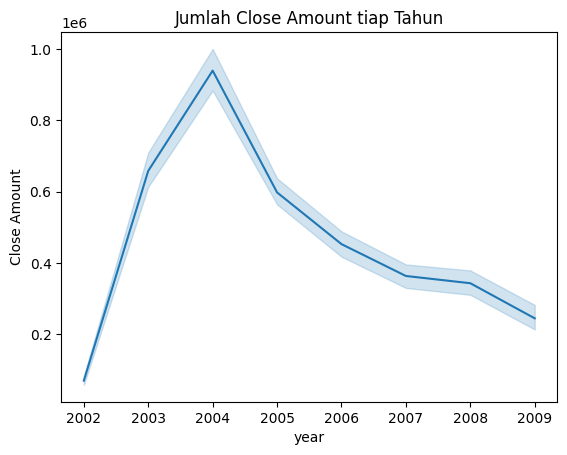

In [54]:
sns.lineplot(data = df, x = "year", y = "Close Amount", estimator = sum)
plt.title('Jumlah Close Amount tiap Tahun')
plt.show()

* Dapat dilihat, setelah tahun 2004 pihak-pihak yang berkaitan dengan airport cukup berhasil menurunkan biaya aduan atau `Claim Amount` yang dikeluarkan oleh TSA tiap tahunnya
* Jumlah biaya aduan atau `Close Amount` paling banyak dikeluarkan oleh TSA adalah pada tahun 2004 dengan biaya aduan mendekati 1 juta dollar kemudian terus turun sampai 2009


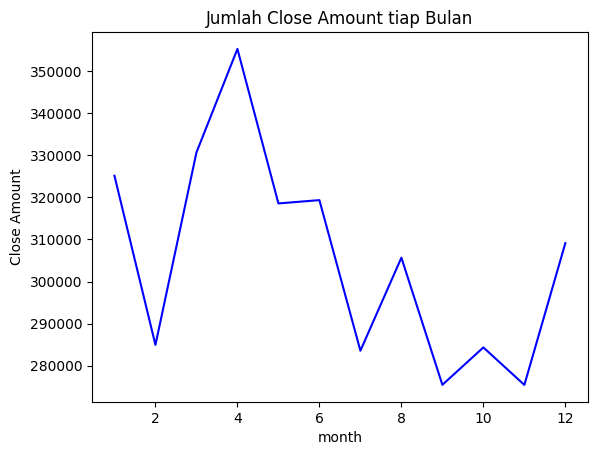

In [79]:
sum_month = pd.DataFrame(df.groupby('month')['Close Amount'].sum()).reset_index()

sns.lineplot(data = sum_month, x = "month", y = "Close Amount", color = 'blue')
plt.title('Jumlah Close Amount tiap Bulan')
plt.show()

tren jumlah biaya aduan atau `Close Amount` **naik dari bulan Desember sampai April**, kemudian turun sampai November 

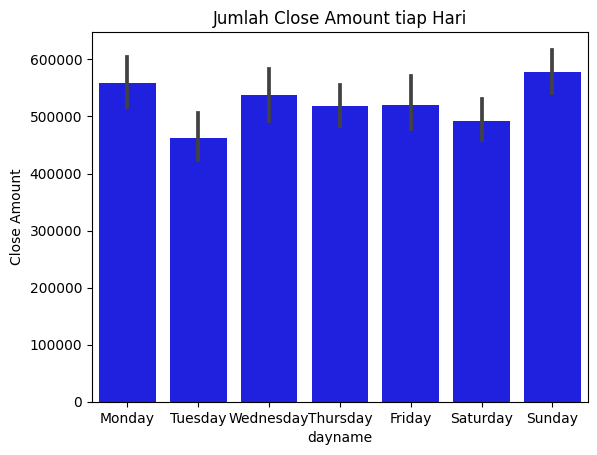

In [100]:
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.barplot(data = df, x = "dayname", y = "Close Amount", color = 'blue', estimator = sum, order= weekdays)
plt.title('Jumlah Close Amount tiap Hari')
plt.show()

Biaya aduan atau `Close Amount` paling banyak dikeluarkan pada kejadian di hari Minggu dan Senin 

## Kerentanan Setiap Bandara / Airport

Untuk menganalisis bandara dalam kolom  `Aiport Code` yang rentan, kita perlu memberikan label kepada semua bandara. 
* Bandara masuk label `rentan` jika bandara tersebut memiliki `Close Amount` lebih dari rata-rata (11.181 dollar)
* Bandara masuk label `tidak rentan` jika bandara tersebut memiliki `Close Amount` kurang dari rata-rata (11.181 dollar)


In [57]:
airport = pd.DataFrame(df.groupby('Airport Code')['Close Amount'].sum()).reset_index().sort_values(by='Close Amount', ascending=False)
airport = airport.reset_index()
airport

a = int(airport['Close Amount'].mean())
b = []
for i in range(0,airport.shape[0]):
    if airport['Close Amount'][i] > a:
        b.append('rentan')
    if airport['Close Amount'][i] < a:
        b.append('tidak rentan')
airport['Status'] = b
airport

,index,Airport Code,Close Amount,Status
0,175,LAX,173058.92,rentan
1,278,SEA,139862.11,rentan
2,230,ORD,138197.10,rentan
3,102,EWR,134260.94,rentan
4,166,JFK,119078.16,rentan
...,...,...,...,...
323,177,LBE,12.56,tidak rentan
324,158,ISO,10.65,tidak rentan
325,228,OME,8.81,tidak rentan
326,24,ATY,8.74,tidak rentan


In [58]:
airport_status = pd.DataFrame(airport.groupby('Status')['Status'].count())
airport_status.rename({'Status':'freq'}, axis = 1, inplace=True)
airport_status = airport_status.reset_index()
airport_status

,Status,freq
0,rentan,68
1,tidak rentan,260


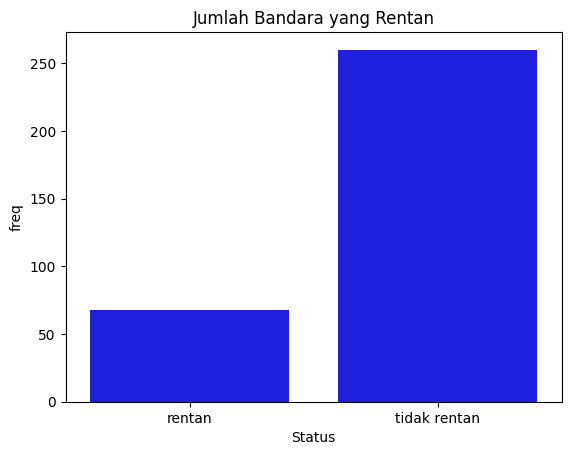

In [59]:
sns.barplot(data = airport_status, x = "Status", y = "freq", color = 'blue')
plt.title('Jumlah Bandara yang Rentan')
plt.show()

Data di atas menunjukkan proporsi bandara yang rentan menghasilkan biaya aduan atau `Close Amount` yang besar yaitu **68 bandara atau sebanyak 26,15% bandara** yang rentan

Selanjutnya, kita ingin melihat persentase bandara yang rentan setiap tahunnya

In [60]:
def rentan_tahun(x):
    data = df[df['year'] == x]
    airport = pd.DataFrame(data.groupby('Airport Code')['Close Amount'].sum()).reset_index().sort_values(by='Close Amount', ascending=False)
    airport = airport.reset_index()
    
    a = int(airport['Close Amount'].mean())
    b = []
    for i in range(0,airport.shape[0]):
        if airport['Close Amount'][i] > a:
            b.append('rentan')
        if airport['Close Amount'][i] < a:
            b.append('tidak rentan')
    airport['Status'] = b
    airport['year'] = x
    airport = airport.drop('index', axis = 1)
    
    return airport

In [61]:
rentan_data = pd.DataFrame()
for i in range(2002,2010):
    a = rentan_tahun(i)
    rentan_data = rentan_data.append(a)
rentan_data

,Airport Code,Close Amount,Status,year
0,JFK,10685.95,rentan,2002
1,LAX,4308.00,rentan,2002
2,ORD,3709.00,rentan,2002
3,BWI,3074.00,rentan,2002
4,EWR,2654.00,rentan,2002
...,...,...,...,...
181,GUM,10.00,tidak rentan,2009
182,STT,8.99,tidak rentan,2009
183,RST,7.48,tidak rentan,2009
184,SBN,6.99,tidak rentan,2009


In [62]:
rentan_persen = pd.DataFrame()

for i in range(2002, 2010):
    tahun = rentan_data[rentan_data['year'] == i]
    a = tahun[tahun['Status'] == 'rentan']
    b = a.shape[0]/tahun.shape[0]*100
    a['percentage'] = b
    rentan_persen = rentan_persen.append(a)

rentan_persen = rentan_persen.reset_index()
rentan_persen

,index,Airport Code,Close Amount,Status,year,percentage
0,0,JFK,10685.95,rentan,2002,30.379747
1,1,LAX,4308.00,rentan,2002,30.379747
2,2,ORD,3709.00,rentan,2002,30.379747
3,3,BWI,3074.00,rentan,2002,30.379747
4,4,EWR,2654.00,rentan,2002,30.379747
...,...,...,...,...,...,...
382,45,DAL,1540.85,rentan,2009,26.881720
383,46,SAT,1502.15,rentan,2009,26.881720
384,47,RNO,1440.55,rentan,2009,26.881720
385,48,CLE,1367.25,rentan,2009,26.881720


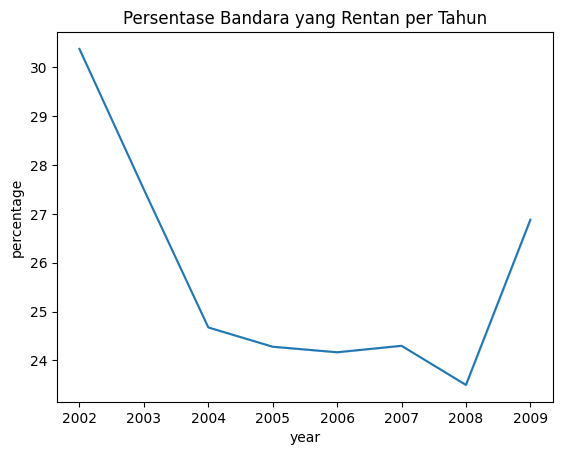

In [63]:
sns.lineplot(data = rentan_persen, x = 'year', y = 'percentage')
plt.title('Persentase Bandara yang Rentan per Tahun')
plt.show()

Dapat dilihat bahwa Bandara yang `rentan` mengalami penurunan drastis sejak 2003 dan sampai pada titik terendah nya di tahun 2008 dengan persentase Bandara yang `rentan` hanya sekitar 23%, namun di tahun 2009 justru ada peningkatan jumlah Bandara yang rentan menjadi sekitar 27% (peningkatan sekitar 14%)

**Artinya pada tahun 2009 terdapat 27% bandara (104 bandara) yang mengharuskan TSA mengeluarkan biaya aduan diatas rata-rata (11.181 dollar) di tiap bandara**

## 2. Kerentanan Berdasarkan Claim Site

Kemudian kita akan menganalisis dimana saja 'kejadian' di Bandara yang menyebabkan TSA harus mengeluarkan biaya aduan `Close Amount` terbanyak

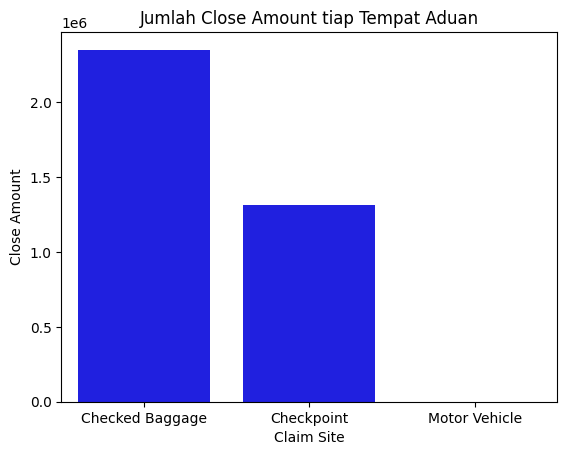

,Claim Site,Close Amount
0,Checked Baggage,2352710.00
1,Checkpoint,1314540.96
2,Motor Vehicle,121.00


In [64]:
# grafik claim site 

sum_site = pd.DataFrame(df.groupby('Claim Site')['Close Amount'].sum()).reset_index()

sns.barplot(data = sum_site, x = "Claim Site", y = "Close Amount", color = 'blue')
plt.title('Jumlah Close Amount tiap Tempat Aduan')
plt.show()

sum_site

Jumlah biaya aduan atau `Close Amount` paling banyak terjadi di **Checked Baggage dengan total biaya aduan yang telah dikeluarkan TSA sekitar 2 juta dollar**

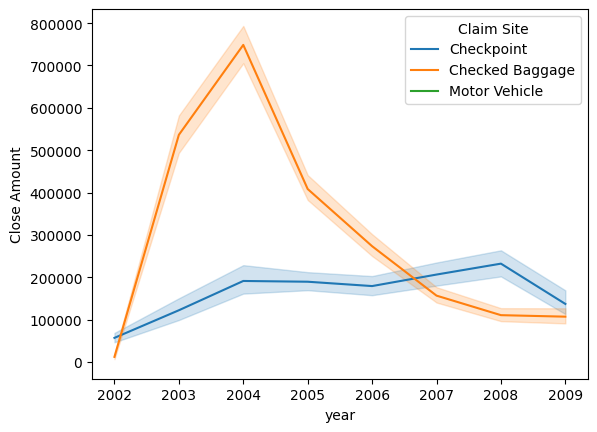

In [65]:
sns.lineplot(data = df, x = 'year', y = 'Close Amount',hue = 'Claim Site',estimator = sum)
plt.show()

Walaupun secara keseluruhan aduan di `Checked Baggage` menghasilkan biaya aduan atau `Close Amount` terbanyak, namun ternyata aduan di `Checked Baggage` trennya terus menurun. Bahkan mulai pada tahun 2007, aduan di `Checkpoint` menghasilkan biaya aduan yang lebih banyak dibandingkan dengan `Checked Baggage`

In [66]:
a = pd.DataFrame(df.groupby('Airport Code')['Close Amount'].sum().sort_values(ascending=False).head(10)).reset_index()
top_airport = df[df['Airport Code'].isin(a['Airport Code'])]

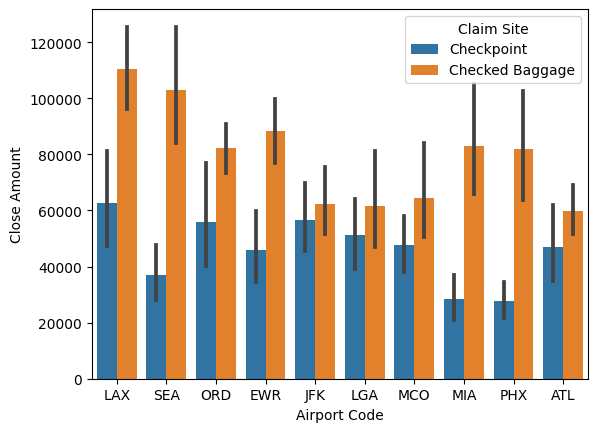

In [118]:
sns.barplot(data = top_airport, x = 'Airport Code', y = 'Close Amount',hue = 'Claim Site', estimator = sum, order = a['Airport Code'])
plt.show()

Jika melihat pada 10 bandara dengan biaya aduan atau `Close Amount` tertinggi, rata-rata tinggi biaya aduan tiap bandara berada di `Checked Baggage`. Secara sekilas kita bisa melihat hanya di MCO, JFK, dan ATL saja yang biaya aduan di `Checkpoint` yang tinggi dan mendekati sama dengan di `Checked Baggage`

## 3. Kerentanan berdasarkan Claim Type

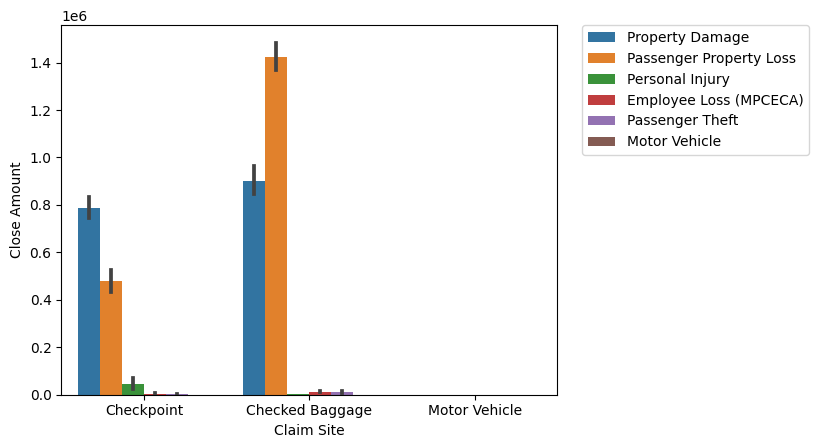

In [88]:
sns.barplot(data = df, x = "Claim Site", y = "Close Amount", hue = 'Claim Type', estimator = sum)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

* Tipe aduan atau `Claim Type` yang paling rentan menghasilkan biaya aduan yang besar adalah aduan kehilangan barang di `Checked Baggage`
* Kerusakan barang penumpang juga membuat TSA perlu mengeluarkan biaya aduan yang besar dan paling banyak berada di `Checkpoint`

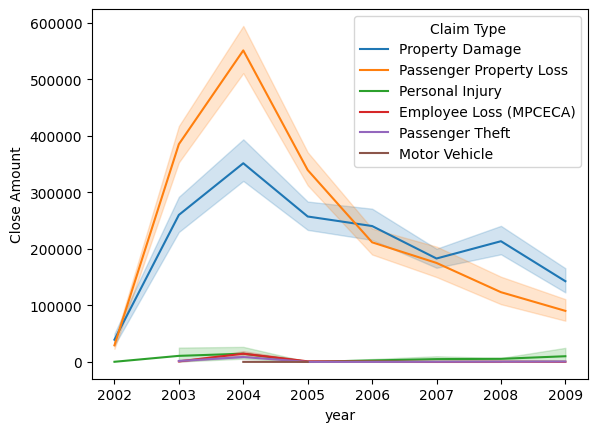

In [89]:
sns.lineplot(data = df, x = 'year', y = 'Close Amount', hue = 'Claim Type', estimator = sum)
plt.show()

Secara umum, tiap bandara berhasil menurunkan kerentanan kehilangan barang dan kerusakan barang, walaupun di tahun 2009 kerusakan barang penumpang sempat kembali naik

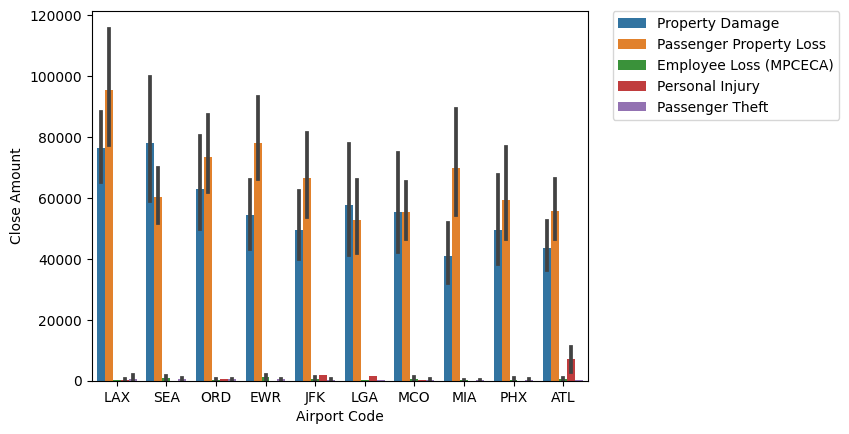

In [117]:
a = pd.DataFrame(df.groupby('Airport Code')['Close Amount'].sum().sort_values(ascending=False).head(10)).reset_index()
top_airport = df[df['Airport Code'].isin(a['Airport Code'])]

sns.barplot(data = top_airport, x = 'Airport Code', y = 'Close Amount',hue = 'Claim Type', estimator = sum, order = a['Airport Code'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

## Rekomendasi

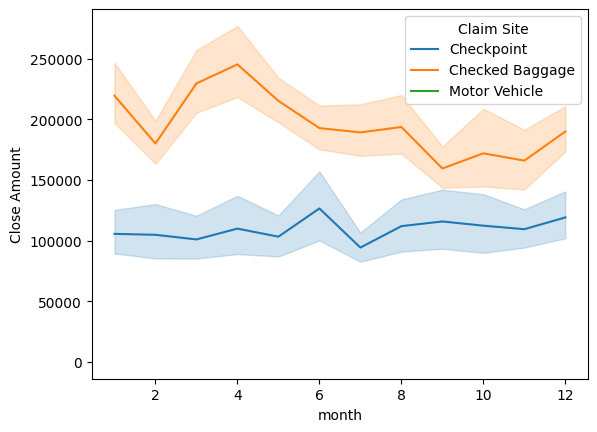

In [96]:
sns.lineplot(data = df, x = 'month', y = 'Close Amount', hue='Claim Site',estimator = sum)
plt.show()

### Site Checkpoint

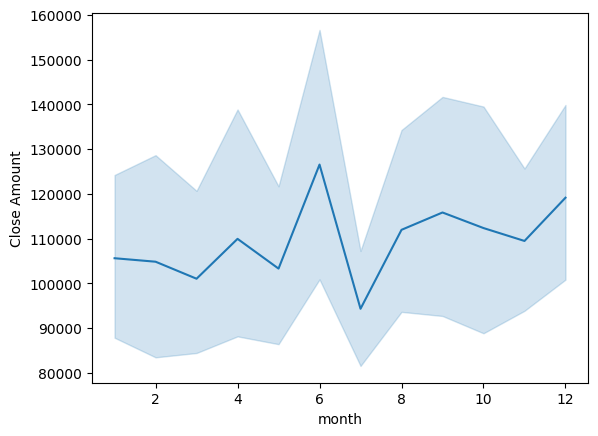

In [95]:
checkpoint = df[df['Claim Site'] == 'Checkpoint']
sns.lineplot(data = checkpoint, x = 'month', y = 'Close Amount',estimator = sum)
plt.show()

untuk Site `Checkpoint` perlu meningkatkan keamanan di bulan **Juni dan Desember**

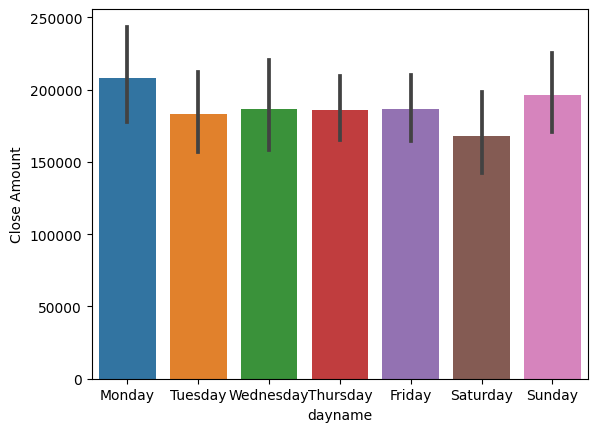

In [103]:
sns.barplot(data = checkpoint, x = 'dayname', y = 'Close Amount',estimator = sum, order = weekdays)
plt.show()

untuk Site `Checkpoint` perlu meningkatkan keamanan di hari **Senin dan Minggu**

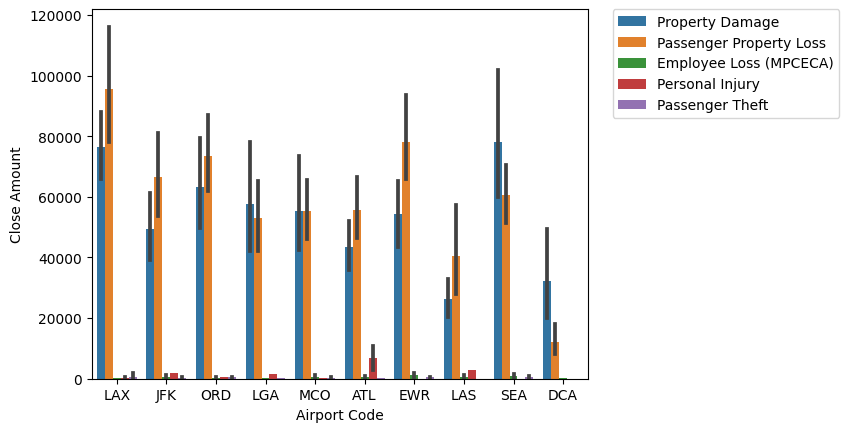

In [111]:
a = pd.DataFrame(checkpoint.groupby('Airport Code')['Close Amount'].sum().sort_values(ascending=False).head(10)).reset_index()
top_checkpoint = df[df['Airport Code'].isin(a['Airport Code'])]

sns.barplot(data = top_checkpoint, x = 'Airport Code', y = 'Close Amount',hue = 'Claim Type', estimator = sum, order = a['Airport Code'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

Khususnya untuk 10 bandara atau airport yang rentan menghasilkan biaya aduan atau `Close Amount` terbesar di Site `Checkpoint`

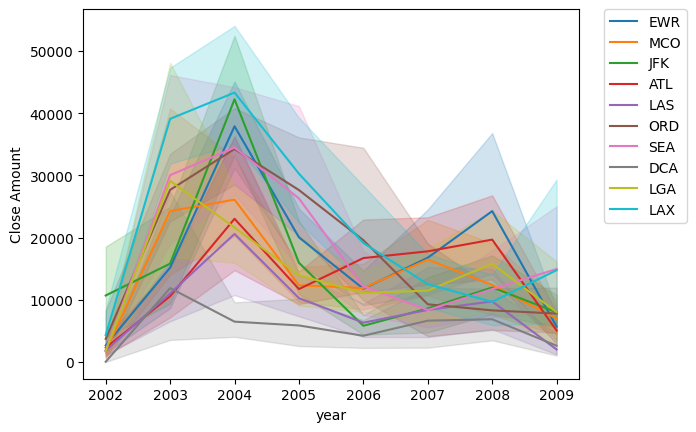

In [120]:
sns.lineplot(data = top_checkpoint, x = 'year', y = 'Close Amount',hue = 'Airport Code', estimator = sum)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

* Pada 10 besar bandara dengan kerntanan pada site Checkpoint tertinggi secara umum trennya menurun
* Namun, untuk bandara SEA dan LAX justru meningkat selama 2 tahun terakhir

### Site Checked Baggage

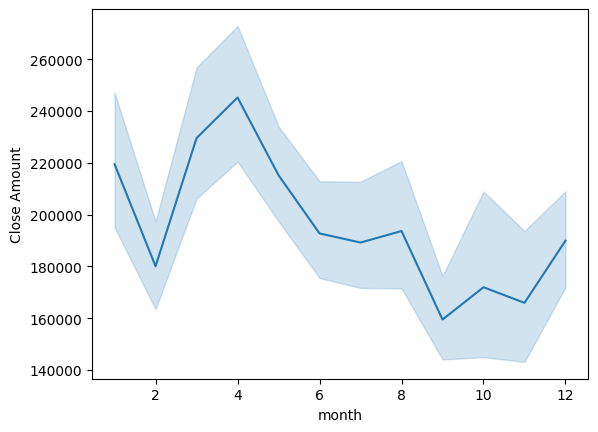

In [104]:
baggage = df[df['Claim Site'] == 'Checked Baggage']
sns.lineplot(data = baggage, x = 'month', y = 'Close Amount',estimator = sum)
plt.show()

untuk Site `Checked Baggage` perlu meningkatkan keamanan di bulan **Januari dan April**

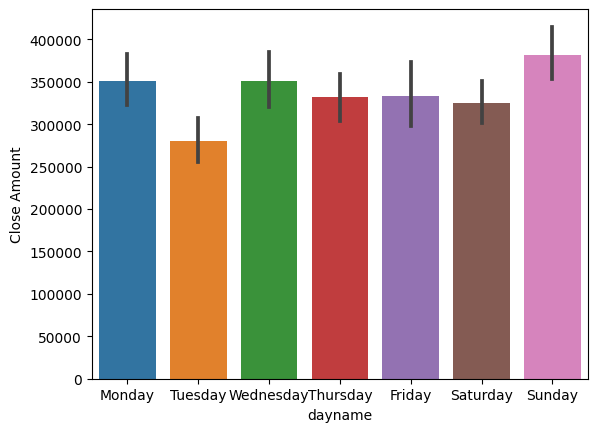

In [105]:
sns.barplot(data = baggage, x = 'dayname', y = 'Close Amount',estimator = sum, order = weekdays)
plt.show()

untuk Site `Checked Baggage` perlu meningkatkan keamanan di hari **Senin, Rabu dan Minggu**

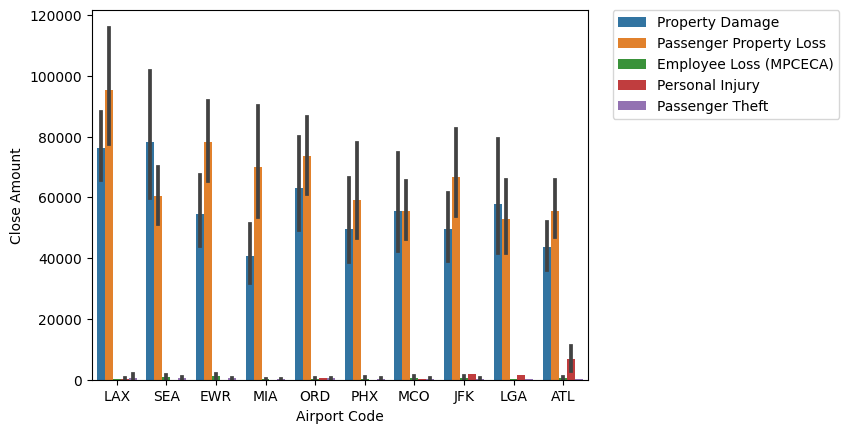

In [114]:
a = pd.DataFrame(baggage.groupby('Airport Code')['Close Amount'].sum().sort_values(ascending=False).head(10)).reset_index()
top_baggage = df[df['Airport Code'].isin(a['Airport Code'])]

sns.barplot(data = top_baggage, x = 'Airport Code', y = 'Close Amount',hue = 'Claim Type', estimator = sum, order = a['Airport Code'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

Khususnya untuk 10 bandara atau airport yang rentan menghasilkan biaya aduan atau `Close Amount` terbesar di Site `Checked Baggage`

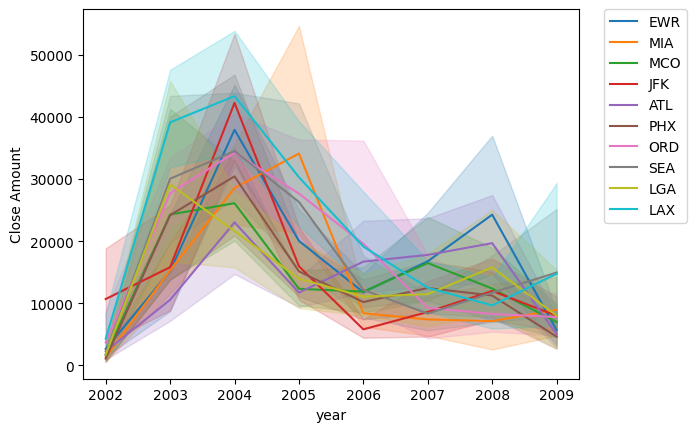

In [121]:
sns.lineplot(data = top_baggage, x = 'year', y = 'Close Amount',hue = 'Airport Code', estimator = sum)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

* Pada 10 besar bandara dengan kerantanan pada site Checked Baggage tertinggi secara umum trennya menurun
* Namun, untuk bandara JFK, SEA, LAX, MIA mengalami kenaikan selama 4 tahun terakhir

# Kesimpulan 

* Setelah tahun 2004 pihak-pihak yang berkaitan dengan airport cukup berhasil menurunkan biaya aduan atau `Claim Amount` yang dikeluarkan oleh TSA tiap tahunnya
* Bandara yang `rentan` mengalami penurunan drastis sejak 2003 dan sampai pada titik terendah nya di tahun 2008 dengan persentase Bandara yang `rentan` hanya sekitar 23%, namun di tahun 2009 justru ada peningkatan jumlah Bandara yang rentan menjadi sekitar 27% (peningkatan sekitar 14%)
* Jumlah biaya aduan atau `Close Amount` paling banyak terjadi di Checked Baggage dengan total biaya aduan yang telah dikeluarkan TSA sekitar 2 juta dollar
* Kerentanan di Checked Baggage tertinggi berada di bandara LAX, SEA dan EWR
* Tipe aduan atau `Claim Type` yang paling rentan menghasilkan biaya aduan yang besar adalah aduan kehilangan barang di Checked Baggage
* Sedangkan, kerentanan tertinggi di Checkpoint berada di bandara LAX, ORD, dan JFK
* Tipe aduan atau `Claim Type` yang paling rentan menghasilkan biaya aduan yang besar adalah aduan kerusakan barang di Checkpoint

# Rekomednasi
* Untuk bandara yang rentan di Checked Baggage
* khususnya untuk bandara JFK, SEA, LAX, MIA perlu ditindak lanjuti karena selama 4 tahun terakhir memiliki tren peningkatan biaya aduan di Checked Baggage
* Rekomendasi bulan yang bisa dimaksimalkan keamanannya adalah pada bulan Januari sampai April
* Rekomendasi hari yang bisa dimaksimalkan keamanannya adalah pada hari Senin, Rabu dan Minggu
* Bandara yang rentan di Checkpoint
* khususnya untuk bandara SEA dan LAX perlu ditindak lanjuti karena selama 2 tahun terakhir memiliki tren peningkatan biaya aduan rentan di Checkpoint
* Rekomendasi bulan yang bisa dimaksimalkan keamanannya adalah pada bulan Juni dan Desember
* Rekomendasi hari yang bisa dimaksimalkan keamanannya adalah pada hari Senin dan Minggu